In [ ]:
!pip install pytorch-lightning torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 22.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class DepthEstimationDataset(Dataset):
    def __init__(self, camera_dir, depth_dir, augment=False):
        self.camera_dir = camera_dir
        self.depth_dir = depth_dir
        self.augment = augment
        self.file_pairs = self.match_files()

    def match_files(self):
        camera_files = sorted(os.listdir(self.camera_dir))
        depth_files = sorted(os.listdir(self.depth_dir))
        file_pairs = []
        for cam_file in camera_files:
            cam_id = cam_file.split("_", 1)[1]
            for dep_file in depth_files:
                dep_id = dep_file.split("_", 1)[1]
                if cam_id == dep_id:
                    file_pairs.append((cam_file, dep_file))
                    break
        if len(file_pairs) == 0:
            raise ValueError("Brak dopasowanych plików.")
        print(f"Znaleziono {len(file_pairs)} dopasowanych par obrazów.")
        return file_pairs

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        camera_file, depth_file = self.file_pairs[idx]
        camera_image = cv2.imread(os.path.join(self.camera_dir, camera_file), cv2.IMREAD_GRAYSCALE)
        depth_image = cv2.imread(os.path.join(self.depth_dir, depth_file), cv2.IMREAD_GRAYSCALE)
        camera_image = cv2.resize(camera_image, (320, 320))
        depth_image = cv2.resize(depth_image, (320, 320))

        camera_image = (torch.tensor(camera_image, dtype=torch.float32) / 255.0 - 0.5) * 2
        depth_image = (torch.tensor(depth_image, dtype=torch.float32) / 255.0 - 0.5) * 2

        return camera_image.unsqueeze(0), depth_image.unsqueeze(0)

In [ ]:
camera_dir = "/content/crazyflie_images/camera"
depth_dir = "/content/crazyflie_images/depth_camera"

dataset = DepthEstimationDataset(camera_dir, depth_dir, augment=False)

camera_image, depth_image = dataset[0]
print(f"Camera image shape: {camera_image.shape}")
print(f"Depth image shape: {depth_image.shape}")

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class UNet(pl.LightningModule):
    def __init__(self, input_channels=1, learning_rate=1e-4):
        super(UNet, self).__init__()
        self.learning_rate = learning_rate

        self.encoder1 = UNetBlock(input_channels, 64)
        self.encoder2 = UNetBlock(64, 128)
        self.encoder3 = UNetBlock(128, 256)
        self.encoder4 = UNetBlock(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = UNetBlock(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = UNetBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = UNetBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = UNetBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = UNetBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

        self.rmse_metric = torchmetrics.MeanSquaredError(squared=False)
        self.mae_metric = torchmetrics.MeanAbsoluteError()

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        dec4 = self.upconv4(middle)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final(dec1)

    def training_step(self, batch, batch_idx):
        images, depths = batch
        preds = self.forward(images)
        loss = nn.MSELoss()(preds, depths)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, depths = batch
        preds = self.forward(images)
        loss = nn.MSELoss()(preds, depths)
        self.rmse_metric.update(preds, depths)
        self.mae_metric.update(preds, depths)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        rmse = self.rmse_metric.compute()
        mae = self.mae_metric.compute()
        self.log("val_rmse", rmse, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)
        self.rmse_metric.reset()
        self.mae_metric.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)



In [ ]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

camera_dir = '/content/crazyflie_images/camera'
depth_dir = '/content/crazyflie_images/depth_camera'

train_dataset = DepthEstimationDataset(camera_dir, depth_dir, augment=True)
val_dataset = DepthEstimationDataset(camera_dir, depth_dir, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

model = UNet(input_channels=1, learning_rate=1e-4)

trainer = Trainer(
    max_epochs=25,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    log_every_n_steps=10
)

trainer.fit(model, train_loader, val_loader)


checkpoint_path = "best_models.ckpt"
trainer.save_checkpoint(checkpoint_path)


In [ ]:
import matplotlib.pyplot as plt
import torch

def show_images(camera_img, predicted_depth, true_depth, idx):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Camera Image")
    plt.imshow(camera_img[0], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Predicted Depth")
    plt.imshow(predicted_depth.squeeze(0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("True Depth")
    plt.imshow(true_depth.squeeze(0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    plt.savefig(f"depth_result_{idx}.png")
    plt.show()

checkpoint_path = "best_models.ckpt"
model = UNet.load_from_checkpoint(checkpoint_path)
model.eval()
model.to("cuda")

batch = next(iter(val_loader))
camera_images, depth_images = batch


with torch.no_grad():
    predicted_depth = model(camera_images.to("cuda"))

for i in range(5):
    show_images(
        camera_images[i].cpu().numpy(),
        predicted_depth[i, 0].unsqueeze(0).cpu(),
        depth_images[i].cpu(),
        idx=i
    )


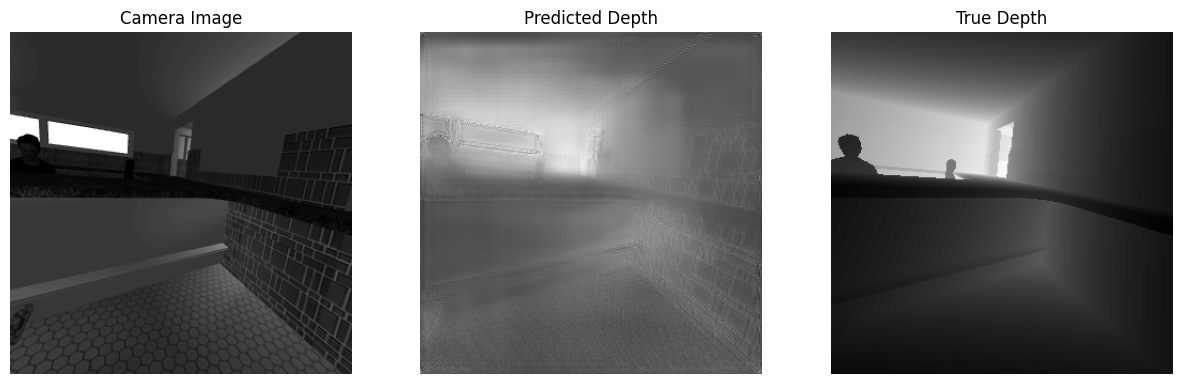